In [3]:
MY_API_TOKEN = 'e815c6fcf6d24a9da234bcd02d7e64bc'

In [68]:
# import http.client
# import json
# connection = http.client.HTTPConnection('api.football-data.org')
# headers = { 'X-Auth-Token': MY_API_TOKEN, 'X-Response-Control': 'minified' }
# connection.request('GET', '/v1/soccerseasons/440/teams', None, headers )
# response = json.loads(connection.getresponse().read().decode())
# pprint(response)
# teams = response['teams']
# print(len(teams))
# team_list = list()
# for team in teams:
#     name = team['shortName']
#     if name:
#         tid = team['id']
#         value = int(team['squadMarketValue'].replace(',','').replace(' €','')) if team['squadMarketValue'] is not None else 0
#         team_list.append({'tid':tid, 'name': name, 'value': value})
# data = pd.DataFrame(team_list)
# data.head()

In [40]:
import pandas as pd
import requests

In [98]:
def call_football_api(uri, result_key):
    result = requests.get(uri, headers = { 'X-Auth-Token': MY_API_TOKEN, 'X-Response-Control': 'full' })
    if result.status_code == 200:
        return result.json()[result_key]
    else:
        print('API is not reachable')
        return None

In [99]:
teams = call_football_api('http://api.football-data.org/v1/soccerseasons/440/teams', 'teams')
# pprint(teams)

In [100]:
teams_data = list()
for team in teams:
    name = team['name']
    tid = team['_links']['self']['href'].split('/')[-1]
    value = int(team['squadMarketValue'].replace(',','').replace(' €','')) if team['squadMarketValue'] is not None else 0
    wins = 0
    fixtures = call_football_api(team['_links']['fixtures']['href'], 'fixtures')
    for f in fixtures:
        if team['name'] == f['homeTeamName']:
            wins += f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        else:
            wins += f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
    teams_data.append({'tid':tid, 'name': name, 'value': value, 'wins': wins})

In [101]:
print(len(teams_data))
data = pd.DataFrame(teams_data)
data.head(32)

32


,name,tid,value,wins
0,FC Basel,729,52900000,3
1,Ludogorez Rasgrad,753,40100000,8
2,FC Bayern München,5,566150000,110
3,FC Rostov,1104,0,15
4,PSV Eindhoven,674,113200000,66
5,Club Atlético de Madrid,78,501500000,72
6,FC Barcelona,81,756500000,117
7,Celtic FC,732,0,8
8,Dynamo Kyiv,842,123250000,8
9,SSC Napoli,113,332775000,88


In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

In [152]:
# fig, ax = plt.subplots(figsize=(15, 12))
# ax.axis('off')

# ax.scatter(data['value'], data['wins'], c='black', s=70)

# for i in range(len(data)):
#     ax.annotate(data['name'][i], (data['value'][i], data['wins'][i]))
    

In [134]:
from scipy.cluster.vq import whiten, kmeans2

In [139]:
whitened = whiten(data[['value', 'wins']].as_matrix())

In [149]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[ 2.18125739,  2.21067163],
        [ 0.88543818,  1.59938743],
        [ 3.17915532,  2.82195583],
        [ 0.17326725,  0.17356513],
        [ 1.38123329,  2.54562188]]),
 array([3, 3, 2, 3, 1, 0, 2, 3, 3, 4, 1, 3, 0, 0, 3, 4, 1, 3, 0, 1, 1, 3, 3,
        1, 2, 1, 1, 3, 0, 1, 0, 4]))

In [150]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]

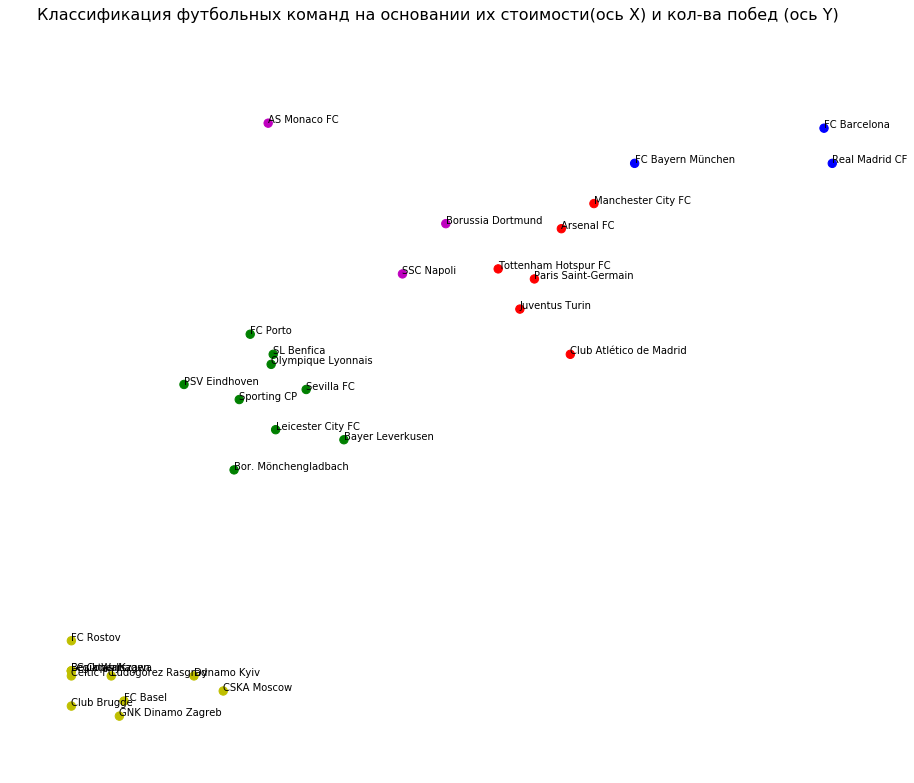

In [151]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.axis('off')
fig.suptitle("Классификация футбольных команд на основании их стоимости(ось Х) и кол-ва побед (ось Y)", fontsize=16)
ax.scatter(data['value'], data['wins'], c=colors, s=70)
for i in range(len(data)):
    ax.annotate(data['name'][i], (data['value'][i], data['wins'][i]))